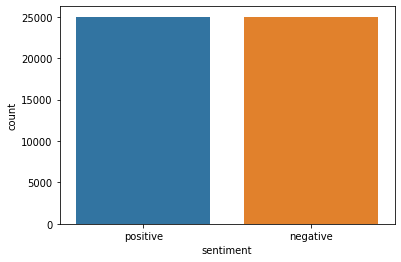

In [54]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

movie_reviews = pd.read_csv("C:\Datasets\imdb_dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

sns.countplot(x='sentiment', data=movie_reviews)

In [3]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []

sentences = list(movie_reviews['review'])

for sen in sentences:
    X.append(preprocess_text(sen))
    
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [4]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [5]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [6]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('C:/Datasets/Word Embeddings/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
print(len(embedding_matrix))

92547


**Text Classification with Simple Neural Network**

In [34]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [36]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 1s 40us/step - loss: 0.6059 - acc: 0.6707 - val_loss: 0.5352 - val_acc: 0.7332
Epoch 2/6
32000/32000 [==============================] - 1s 27us/step - loss: 0.5007 - acc: 0.7575 - val_loss: 0.5266 - val_acc: 0.7385
Epoch 3/6
32000/32000 [==============================] - 1s 26us/step - loss: 0.4573 - acc: 0.7882 - val_loss: 0.5255 - val_acc: 0.7402
Epoch 4/6
32000/32000 [==============================] - 1s 28us/step - loss: 0.4398 - acc: 0.7970 - val_loss: 0.5193 - val_acc: 0.7445
Epoch 5/6
32000/32000 [==============================] - 1s 29us/step - loss: 0.4206 - acc: 0.8075 - val_loss: 0.5255 - val_acc: 0.7459
Epoch 6/6
32000/32000 [==============================] - 1s 29us/step - loss: 0.4105 - acc: 0.8141 - val_loss: 0.5310 - val_acc: 0.7424


In [37]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 0s 27us/step


In [38]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5334349925518036
Test Accuracy: 0.7433


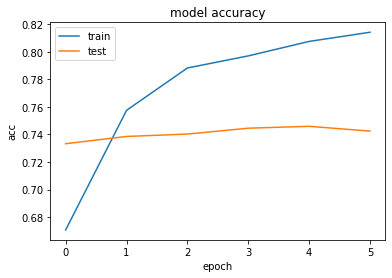

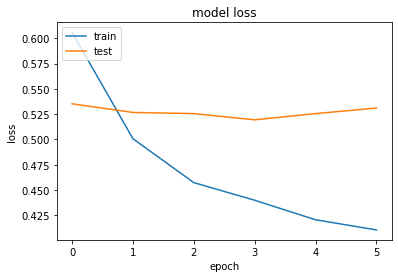

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**Text Classification with a Convolutional Neural Network**

In [48]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [49]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [50]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 22s 678us/step - loss: 0.5046 - acc: 0.7514 - val_loss: 0.3925 - val_acc: 0.8235
Epoch 2/6
32000/32000 [==============================] - 21s 647us/step - loss: 0.3663 - acc: 0.8397 - val_loss: 0.4016 - val_acc: 0.8143
Epoch 3/6
32000/32000 [==============================] - 21s 653us/step - loss: 0.3153 - acc: 0.8656 - val_loss: 0.3534 - val_acc: 0.8386
Epoch 4/6
32000/32000 [==============================] - 21s 649us/step - loss: 0.2795 - acc: 0.8855 - val_loss: 0.3508 - val_acc: 0.8431
Epoch 5/6
32000/32000 [==============================] - 21s 651us/step - loss: 0.2452 - acc: 0.9057 - val_loss: 0.3422 - val_acc: 0.8498
Epoch 6/6
10000/10000 [==============================] - 2s 248us/step


In [51]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3388665519237518
Test Accuracy: 0.8502


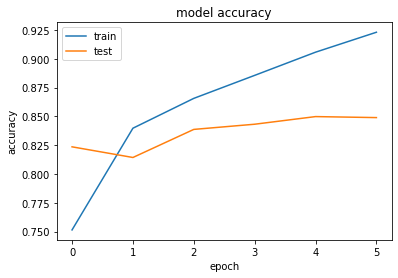

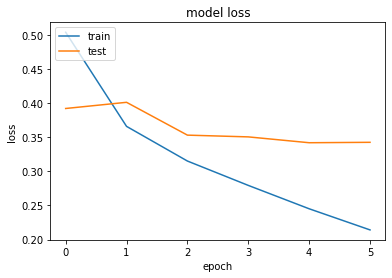

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

**Text Classification with Recurrent Neural Network (LSTM)**

In [55]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [56]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [57]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 247s 8ms/step - loss: 0.5693 - acc: 0.6994 - val_loss: 0.4718 - val_acc: 0.7802
Epoch 2/6
32000/32000 [==============================] - 242s 8ms/step - loss: 0.4337 - acc: 0.8010 - val_loss: 0.4067 - val_acc: 0.8259
Epoch 3/6
32000/32000 [==============================] - 237s 7ms/step - loss: 0.3805 - acc: 0.8285 - val_loss: 0.3879 - val_acc: 0.8276
Epoch 4/6
32000/32000 [==============================] - 264s 8ms/step - loss: 0.3591 - acc: 0.8397 - val_loss: 0.3797 - val_acc: 0.8369
Epoch 5/6
32000/32000 [==============================] - 352s 11ms/step - loss: 0.3386 - acc: 0.8513 - val_loss: 0.3558 - val_acc: 0.8409
Epoch 6/6
10000/10000 [==============================] - 113s 11ms/step


In [58]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3501913533687592
Test Accuracy: 0.8397


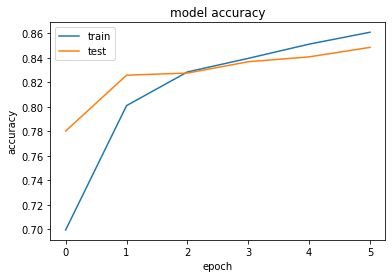

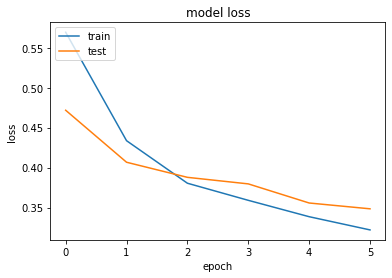

In [59]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [60]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [61]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.65969056]], dtype=float32)